In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
from tqdm import tqdm

# Load the posterior

In [5]:
# Save model
features_str = '200clExp_Sagitta_NEW_noAVfeh_pred'
fin_folder = '/Users/ratzenboe/Documents/work/code/notebooks/SBI/trained_models/'
fout_folder = '/Users/ratzenboe/Documents/work/code/notebooks/SBI/posterior_samples_validation/'

with open(fin_folder + f"posterior_{features_str}.pkl", "rb") as handle:
    posterior = pickle.load(handle)
    
with open(fin_folder + f"scale_factors_{features_str}.pkl", "rb") as handle:
    scale_factors = pickle.load(handle)

with open(fin_folder + f'features_{features_str}.pkl', 'rb') as handle:
    features_X_y = pickle.load(handle)

In [33]:
# features_X_y

# Load the data

In [107]:
fpath_data = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/mock_cluster_500pc_3Myr.csv'
# fpath_data = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/test_set_sagitta_noAVfeh_pred.csv'
df = pd.read_csv(fpath_data)
df.rename(columns={'logAge_true': 'logAge'}, inplace=True)

has_all_feats = df[features_X_y['X']].isna().sum(axis=1)==0
df['used_for_test'] = has_all_feats
df['id'] = -1
df.loc[has_all_feats, 'id'] = np.arange(np.sum(has_all_feats))

In [137]:
df.to_csv('/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/mock_cluster_500pc_3Myr_May2024.csv', index=False)

In [108]:
df_test = df.loc[has_all_feats]

In [149]:
df_test.columns

Index(['ra_obs', 'dec_obs', 'parallax_obs', 'pmra_obs', 'pmdec_obs',
       'radial_velocity_obs', 'phot_g_mean_mag_obs', 'phot_bp_mean_mag_obs',
       'phot_rp_mean_mag_obs', 'j_obs', 'h_obs', 'k_obs', 'w1_obs', 'w2_obs',
       'w3_obs', 'w4_obs', 'irac1_obs', 'irac2_obs', 'irac3_obs', 'irac4_obs',
       'mips1_obs', 'M_G', 'X_obs', 'Y_obs', 'Z_obs', 'U', 'V', 'W',
       'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error',
       'radial_velocity_error', 'phot_g_mean_mag_error',
       'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error', 'j_error',
       'h_error', 'k_error', 'w1_error', 'w2_error', 'w3_error', 'w4_error',
       'irac1_error', 'irac2_error', 'irac3_error', 'irac4_error',
       'mips1_error', 'parallax_true', 'mass_true', 'is_binary_true', 'X_true',
       'Y_true', 'Z_true', 'logAge', 'feh_true', 'A_V_true', 'A_V_obs',
       'used_for_test', 'id'],
      dtype='object')

In [109]:
x_orig = torch.tensor(df_test[features_X_y['X']].values.astype(np.float32))
theta_orig = torch.tensor(df_test[features_X_y['y']].values.astype(np.float32))

In [110]:
# Scale the data
x_samples = (x_orig - scale_factors['x_mean']) / scale_factors['x_std']
theta_samples = (theta_orig - scale_factors['theta_mean']) / scale_factors['theta_std']

In [111]:
val_fraction = 1
n_samples_val = int(val_fraction * x_samples.shape[0])
idx_subset = np.arange(x_samples.shape[0])
# np.random.shuffle(idx_subset)
idx_subset = idx_subset  #[:n_samples_val]

In [113]:
post_info = {}

i = 0
for idx_i in tqdm(idx_subset):
    posterior_samples = posterior.sample((1_000,), x=x_samples[idx_i], show_progress_bars=False)
    # plx_post, logAge_post, A_V_post, feh_post = (
    plx_post, logAge_post = (
            posterior_samples * scale_factors['theta_std'] + scale_factors['theta_mean']).numpy().T
    # plx_true, logAge_true, A_V_true, feh_true = (
    plx_true, logAge_true = (
            theta_samples[idx_i] * scale_factors['theta_std'] + scale_factors['theta_mean']).numpy().T

    post_info[idx_i] = {
        'post_samples': posterior_samples * scale_factors['theta_std'] + scale_factors['theta_mean'],
        'true': theta_samples[idx_i] * scale_factors['theta_std'] + scale_factors['theta_mean'],
        'plx_post': plx_post,
        'plx_true': plx_true,
        'logAge_post': logAge_post,
        'logAge_true': logAge_true,
        # 'A_V_post': A_V_post,
        # 'A_V_true': A_V_true,
        # 'feh_post': feh_post,
        # 'feh_true': feh_true
    }
    i+=1

100%|██████████| 572/572 [00:04<00:00, 118.70it/s]


In [70]:
# post_info['validation_set'] = df.loc[idx_subset]

In [138]:
fout_folder

'/Users/ratzenboe/Documents/work/code/notebooks/SBI/posterior_samples_validation/'

In [140]:
with open(fout_folder + f"{features_str}_unseen_clusters.pkl", "wb") as handle:
    pickle.dump(post_info, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [141]:
fout_folder + f"{features_str}_unseen_cluster_500pc_3Myr.pkl"

'/Users/ratzenboe/Documents/work/code/notebooks/SBI/posterior_samples_validation/200clExp_Sagitta_NEW_noAVfeh_pred_unseen_cluster_500pc_3Myr.pkl'

# Quick results plot

In [116]:
def mode_reals(array, bins=150):
    counts, bin_edges = np.histogram(array, bins=bins)
    # Take left edges as approximation for bin midpoint
    bins_left_edges = bin_edges[:-1]
    return bins_left_edges[np.argmax(counts)]

In [147]:
f_summary = np.mean

dist_pred = np.array([f_summary(1000/post_info[i]['plx_post']) for i in df.loc[has_all_feats].id.values])
dist_true = np.array([1000/post_info[i]['plx_true'] for i in df.loc[has_all_feats].id.values])
dist_obs = 1000/df_test['parallax_obs'].values

logAge_pred = np.array([f_summary(post_info[i]['logAge_post']) for i in df.loc[has_all_feats].id.values])
logAge_true = np.array([post_info[i]['logAge_true'] for i in df.loc[has_all_feats].id.values])

# feh_pred = np.array([f_summary(post_info[i]['feh_post']) for i in np.arange(max_int)])
# A_V_pred = np.array([f_summary(post_info[i]['A_V_post']) for i in np.arange(max_int)])

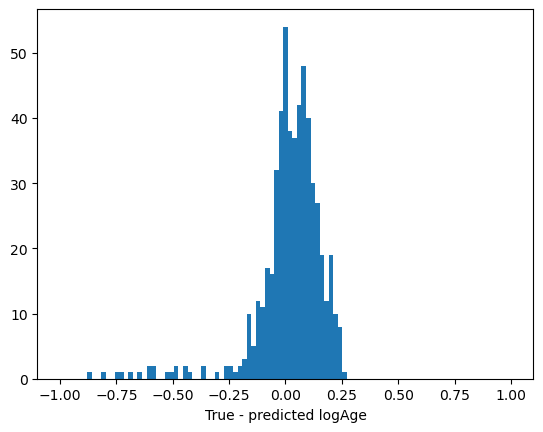

In [148]:
# plt.scatter(logAge_true, logAge_pred, s=1, alpha=1, c=df_test.is_binary_true) #, c=df_val.labels==21)
# plt.xlabel('True logAge')
# plt.ylabel('Predicted logAge')
# min_age, max_age = 4, 10.5
# plt.plot([min_age, max_age], [min_age, max_age], color='k')
# plt.xlim(min_age, max_age)
# plt.ylim(min_age, max_age)
# plt.show()

plt.hist(logAge_true - logAge_pred, bins=np.linspace(-1, 1, 100))
plt.xlabel('True - predicted logAge')
# plt.ylabel('Predicted logAge')
plt.show()

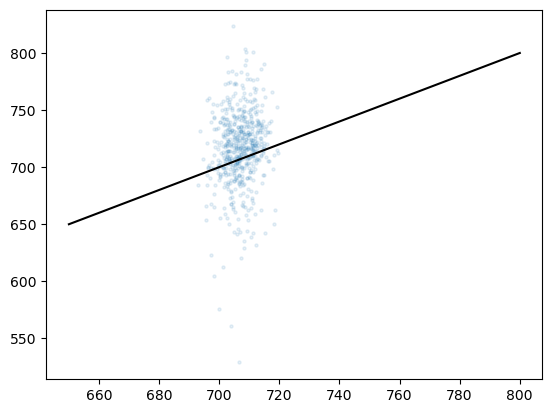

In [135]:
plt.scatter(dist_true, dist_pred, s=5, alpha=0.1) #, c=df_val.labels==21)
plt.plot([650, 800], [650, 800], color='k')

In [82]:
# plt.scatter(df_val.feh, feh_pred, s=5, alpha=0.1)
# plt.xlim(-1, 0.5)
# plt.ylim(-1, 0.5)
# plt.plot([-1, 0.5], [-1, 0.5], color='k')

In [83]:
# plt.scatter(df_val.A_V, A_V_pred, s=5, alpha=0.1)
# plt.xlim(-0.1, 4)
# plt.ylim(-0.1, 4)
# plt.plot([-0.1, 4], [-0.1, 4], color='k')

In [84]:
# plt.hist(df_val.A_V - A_V_pred, bins=100, range=(-0.3, 0.3), log=True)